In [1]:
# Following file was inspired by the following tutorial:
# https://colab.research.google.com/drive/1SiF0KZJp75rUeetKOWqpsA8clmHP6jMg?usp=sharing#scrollTo=d7utFz27cO9q

# And use this cource for explanation:
# https://bruno-yun.notion.site/The-Transformer-Model-for-NLG-c4413bd5a8044325a7658cb8ff5535f2
# https://web.stanford.edu/~jurafsky/slp3/9.pdf

In [2]:
from importlib.metadata import version
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import math
from dataclasses import dataclass

Intro, bla bla bla

In [3]:
# Temporaire
VOCAB_SIZE = 2 # For now we are only using binary data (0, 1) later can be modify by 12
CONTEXT_LENGHT = 3 # And we are using a context of 3 bits (may be changed later)

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads,
                 qkv_bias = False):
        
        super().__init__()
        assert( d_out % num_heads == 0), "d_out should be divisible by num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        
        # self.W_query = nn.Linear(d_in, d_out, bias = qkv_bias)
        # self.W_key = nn.Linear(d_in, d_out, bias = qkv_bias)
        # self.W_value = nn.Linear(d_in, d_out, bias = qkv_bias) 
        # Don't use this because we want to have only one projection to optimize
        # To have only one projection we use the following line
        self.W_qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias) 

        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(d_out, d_out)
        self.register_buffer('mask', 
                            torch.triu(torch.ones(context_length,context_length), 
                                                diagonal=1))
        
    def forward(self,x: torch.Tensor):
        queries: torch.Tensor
        keys: torch.Tensor
        values: torch.Tensor
        b, num_tokens, d_in = x.shape # b, num_token, d_in

        # self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        # self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        # self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        # Use one projection to get queries, keys and values
        # self.W_qkv(x) -> b, num_token, 3*d_out (is a tensor)
        # chunk(3, dim=-1) -> b, num_token, d_out we split the tensor in 3 parts
        queries, keys, values= self.W_qkv(x).chunk(3, dim=-1)
        
        # b, num_token, numheads, head_dim
        queries = queries.reshape(b,
                                num_tokens,
                                self.num_heads,
                                self.head_dim
                            ).transpose(1, 2)
        keys = keys.reshape(b,
                            num_tokens,
                            self.num_heads,
                            self.head_dim
                        ).transpose(1, 2)
        values = values.reshape(b,
                                num_tokens,
                                self.num_heads,
                                self.head_dim
                            ).transpose(1, 2)
        
        # b, num_heads, num_token, num_token
        attn_scores = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
        
        attn_scores = attn_scores.masked_fill(
            self.mask[:num_tokens, :num_tokens].unsqueeze(0).unsqueeze(0).bool() == 1, 
            float('-inf')
        )

        attn_weights = nn.functional.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context = torch.einsum('bhqk, bhkd -> bhqd', 
                               attn_weights, 
                               values
                            ).transpose(1, 2).reshape(b, num_tokens, self.d_out)
        
        
        return self.out_proj(context)
    

# Explain of class MultiHeadAttention
In transformers model, the **MultiHeadAttention** class is used to apply attention mechanisms to input sequences. Understanding how this class works requires first exploring **single-head** attention before generalizing to **multi-head attention**.

## Single-Head Attention
Attention in Transformers relies on measuring the similarity between tokens in a sequence. This measurement is performed using three distinct transformations:

- Query (Q): Represents the current token’s focus when comparing it to all other tokens.
- Key (K): Represents a token being compared to the query.
- Value (V): Represents the actual information to be aggregated based on attention scores.

These three representations are obtained by applying linear transformations to the input sequence. The transformed matrices allow us to compute the attention scores using the scaled dot-product attention formula:

$ 
score(x_i, x_j) = \frac{q_i \cdot k_j}{\sqrt{d_k}} 
$

Where $q_i$ is the query representation of token $i$, $k_j$ is the key representation of token $j$, and $d_k$ is the dimension of the key representation. 

In forward function is :
```python
attn_scores = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
```

To prevent a token from attending to future tokens (as in autoregressive models like GPT), we apply a mask to the attention scores. This ensures that each token only attends to itself and previous tokens:

$
a_i = \sum_{j \leq i} \alpha_{ij}v_j
$

In forward function is :
```python
attn_scores = attn_scores.masked_fill(self.mask[:num_tokens, :num_tokens] == 0,
                                float('-inf'))
```

Once the attention scores are computed and masked, they are normalized using the softmax function to produce attention weights:

$
\alpha_{ij} = \frac{\exp(score(x_i,x_j))}{\sum_j \exp(score(x_i,x_j))}
$

In forward function is :
```python
attn_scores = nn.fonctional.softmax(attn_scores, dim=-1)
```

To prevent overfitting, a dropout layer is applied to the attention weights (self.dropout) before computing the context vector.

To compute the context vector, we multiply the attention weights by the Value (V) representations to obtain the context vector.

In forward function is :

```python
context = torch.einsum('bhqk, bhkd -> bhqd', attn_weights, values)
```

To resume we have done this :

![explain one head](./img/ExplainOneHeadAttention.png)
*Source: [Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/9.pdf)*

## Multi-Head Attention
Single-head attention allows each token to focus on others, but it has limitations: it can only capture one type of relationship at a time. Multi-head attention improves this by using multiple attention heads in parallel.
Instead of computing attention once, we split the input into multiple heads, each with a different representation of the sequence. This allows the model to capture diverse patterns.
All heads are concatenated and linearly transformed to produce the final output. This process is implemented in the **MultiHeadAttention**, is why we use self.head_dim or 'd' in code.

This figure resume compute with matrix :

![Compute](./img/ExplainCompute.png)
*Source: [Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/9.pdf)*


In [5]:
class FeedForward(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            nn.GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )
        
    def forward(self,x):
        return self.layers(x)

# The FeedForward in transformer
The **FeedForward** class is used to apply a feedforward neural network to the output of the multi-head attention layer. The feedforward network consists of two linear transformations with a GELU (or RELU) activation function in between.

## GELU and RELU
GELU and RELU are activation functions used in neural networks after linear transformations. GELU is a smoother version of RELU that has been shown to improve performance in transformer models. 

The GELU function is defined as:

$
GELU(x) = 0.5x(1 + tanh(\sqrt{2/\pi}(x + 0.044715x^3)))
$

RELU is a simpler activation function that sets all negative values to zero:

$
RELU(x) = max(0, x)
$



In [6]:
class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.norm1 = nn.LayerNorm(cfg["emb_dim"])
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            dropout = cfg["drop_rate"],
            num_heads = cfg["n_heads"],
            qkv_bias = cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm2 = nn.LayerNorm(cfg["emb_dim"])
        self.dropout = nn.Dropout(cfg["drop_rate"])
        
    def forward(self,x):
        # print("we are in one transformer block")
        # print(x.shape)
        # print(x)
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        # print("after att", x.shape)
        # print(x)
        x = self.dropout(x)

        x = x + shortcut
        
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = x+ shortcut
        # print(x.shape)
        # print(x)
        # print('end trs block')
        return x

# Explain of class TransformerBlock
The **TransformerBlock** class is the core building block of the transformer model. It consists of three main components: the **MultiHeadAttention**, the **FeedForward** layers and **LayerNorm**. The **MultiHeadAttention** layer is used to capture the relationships between tokens, while the **FeedForward** layer is used to apply non-linear transformations to the output of the attention layer. We use **LayerNorm** to normalize X and for normalize the output of the **FeedForward** layer.

![image.png](./img/ExplainArchiTrans.png)
*Source: [Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/9.pdf)*

In this figure we can see the Residual Stream. In the forward funciton it's name shortcut. It's a way to avoid the vanishing gradient problem. The output of the **FeedForward** layer is added to the input of the **MultiHeadAttention** layer. This allows the model to learn the difference between the input and output of the block, which helps to improve performance.




In [7]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        
        # Embeddings
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Transformer Blocks
        self.trf_blocks = nn.ModuleList(
                [TransformerBlock(cfg) for _ in range(cfg["n_leayers"])]
            )
        
        # Normalization & Output layer
        self.final_norm = nn.LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
        
        # Weight tying: Share weights between embedding and output projection
        self.tok_emb.weight = self.out_head.weight
        
        # Initialize weights (If we need)
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
        # Special initialization for transformer projection layers
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p,
                                    mean=0.0,
                                    std=0.02 / math.sqrt(2 * self.cfg["n_layers"]))
                
    def forward(self, x: torch.Tensor, return_full_sequence=True):
        b, seq_len = x.shape
        device = x.device

        # print("in GPT, forward ",x)
        
        # Token & Positional Embeddings
        # (b, seq_len, emb_dim)
        tok_embeds = self.tok_emb(x)
        # print("tok_embeds ",tok_embeds)
        # (seq_len, emb_dim)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=device))
        # print("pos_embeds ",pos_embeds)
        
        x = tok_embeds + pos_embeds
        # print("tok_embeds + pos_embeds ",x)
        x = self.drop_emb(x)
        # print("self.drop_emb(x) ",x)
        
        # Pass through Transformer Blocks
        deleteme = 0
        for block in self.trf_blocks:
            deleteme += 1
            x = block(x)
            # print(f"block(x) n°{deleteme} : {x}")
        
        # Final normalization & output projection
        x = self.final_norm(x)
        # print("self.final_norm(x) ",x)
        logits = self.out_head(x)

        # print("logits ",logits)
        
        if not return_full_sequence:
            logits = logits[:, -1, :]  # (b, vocab_size)
        
        return logits

In [8]:
GPT_CONFIG_124M_small = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_leayers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

OUR_CONFIG = {
    "vocab_size": VOCAB_SIZE,
    "context_length": CONTEXT_LENGHT,
    "emb_dim": 16,
    "n_heads": 4,
    "n_leayers": 4,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [9]:
def all_possible(n, k):
    # return all possible lists of k elements, each in range of [0,n)
    if k == 0:
        yield []
    else:
        for i in range(n):
            for c in all_possible(n, k - 1):
                yield [i] + c
                
list(all_possible(VOCAB_SIZE, CONTEXT_LENGHT))

[[0, 0, 0],
 [0, 0, 1],
 [0, 1, 0],
 [0, 1, 1],
 [1, 0, 0],
 [1, 0, 1],
 [1, 1, 0],
 [1, 1, 1]]

input [0, 0, 0] ---> [0.5524600744247437, 0.44753989577293396]
input [0, 0, 1] ---> [0.47954434156417847, 0.5204555988311768]
input [0, 1, 0] ---> [0.5379564166069031, 0.46204355359077454]
input [0, 1, 1] ---> [0.4603937268257141, 0.5396062731742859]
input [1, 0, 0] ---> [0.5444108247756958, 0.4555891156196594]
input [1, 0, 1] ---> [0.4618186056613922, 0.5381813645362854]
input [1, 1, 0] ---> [0.5288079977035522, 0.47119200229644775]
input [1, 1, 1] ---> [0.4674224555492401, 0.5325775146484375]


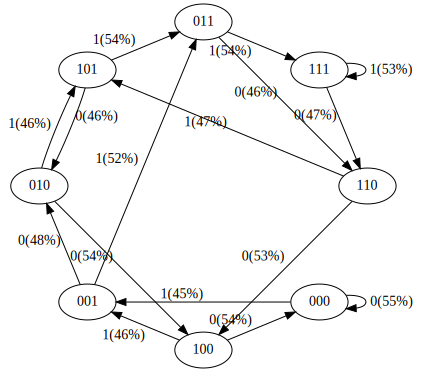

In [12]:
from graphviz import Digraph

gpt = GPTModel(OUR_CONFIG)
def plot_model():
    dot = Digraph(comment='Baby GPT', engine='circo')

    for xi in all_possible(VOCAB_SIZE, CONTEXT_LENGHT):
        
        # forward the GPT and get probabilities for next token
        x = torch.tensor(xi, dtype=torch.long)[None, ...]
        # turn the list into a torch tensor and add a batch dimension
        logits = gpt(x, False) # forward the gpt neural net
        # print('logits :', logits)
        probs = nn.functional.softmax(logits, dim=-1) # get the probabilities
        y = probs[0].tolist() # remove the batch dimension and unpack the tensor into simple list
        print(f"input {xi} ---> {y}")

        # also build up the transition graph for plotting later
        current_node_signature = "".join(str(d) for d in xi)
        dot.node(current_node_signature)
        # input("Press Enter to continue...")

        for t in range(VOCAB_SIZE):
            next_node = xi[1:] + [t] # crop the context and append the next character
            next_node_signature = "".join(str(d) for d in next_node)
            p = y[t]

            label=f"{t}({p*100:.0f}%)"
            dot.edge(current_node_signature, next_node_signature, label=label)
    
    return dot

plot_model()    

In [11]:
model = GPTModel(OUR_CONFIG)

with torch.no_grad():
    logits = model(torch.randint(0, VOCAB_SIZE, (1, CONTEXT_LENGHT)))

probas = torch.softmax(logits, dim=-1) 
output = torch.argmax(probas, dim=-1, keepdim=True)
output

tensor([[[0],
         [0],
         [0]]])